In [1]:
##All the imports
import numba
from numba import cuda

#from ipynb.fs.full.readRaw import readVolume
import json
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors


from sklearn.cluster import AffinityPropagation 
from sklearn import metrics 

import timeit
from PIL import Image

In [2]:
print(cuda.gpus)
cuda.select_device(1)

<Managed Device 0>, <Managed Device 1>, <Managed Device 2>, <Managed Device 3>


<weakproxy at 0x7f32856a3ae0 to Device at 0x7f332815f0d0>

In [3]:
def ParseJSON(fname):
    contents = dict()
    # Opening JSON file -- used this as reference: https://www.geeksforgeeks.org/convert-json-to-dictionary-in-python/
    with open(fname) as json_file: 
        contents = json.load(json_file) 

        # Print the type of data variable 
        print("Type:", type(contents)) 


    #Store the information
    volumeInfo = {}
    volumeInfo['name']    = contents["name"]
    volumeInfo['type']    = contents["type"]
    volumeInfo['size']    = contents["size"]
    volumeInfo['spacing'] = contents["spacing"]
    volumeInfo['fname']   = os.path.basename(contents["url"])
    
    
    ##This uses code from here: https://stackoverflow.com/questions/1124810/how-can-i-find-path-to-given-file
    for root, dirs, files in os.walk(r'../../'):
        for name in files:
            if name == volumeInfo['fname']:
                print(os.path.abspath(os.path.join(root, name)))
                volumeInfo['dpath']   = os.path.abspath(os.path.join(root, name))


    print(volumeInfo)
    return volumeInfo

##number of bytes for a datatype
def SizeOf(dataType):

    if (dataType == "uchar"):
        return 1
    if (dataType == "char"):
        return 1
    if (dataType == "uint8"):
        return 1
    if (dataType == "uint16"):
        return 2
    if (dataType == "uint32"):
        return 4
    if (dataType == "uint64"):
        return 8
    if (dataType == "int8"):
        return 1
    print("Error: Unrecognized type", dataType)



def ParseRaw(volumeInfo):
    print(volumeInfo['type'])
    voxel_size = SizeOf(volumeInfo['type'])
    nbytes_per_line = volumeInfo['size'][0] * voxel_size
    num_of_lines    = volumeInfo['size'][1] * volumeInfo['size'][2]
    fname = volumeInfo['dpath']
    
    ##this is hardcoded to int values
    data_ptr = np.zeros(volumeInfo['size'], dtype = np.int)

    
    print("Reading the RAW file")
    
    file = open(fname, "rb") ##it's a binary file
    
    for line in range(num_of_lines):
        #print("\n\n", [char for char in file.read(nbytes_per_line)])
        y_idx = line % nbytes_per_line
        z_idx = line // volumeInfo['size'][1]
        #print(line, y_idx, z_idx)
        data_ptr[:][y_idx][z_idx] = [char for char in file.read(nbytes_per_line)]
        
    file.close()
    return data_ptr

def readVolume(fname):
    volumeInfo = ParseJSON(fname)
    data_ptr   = ParseRaw(volumeInfo)
    return data_ptr, volumeInfo

#Time to do gradient calculation
@cuda.jit
def setGradients(data_ptr, grad_ptr, grad_mag_ptr, data_size):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y*cuda.blockDim.y + cuda.threadIdx.y
    k = cuda.blockIdx.z*cuda.blockDim.z + cuda.threadIdx.z

    x_size = data_size[0]
    y_size = data_size[1]
    z_size = data_size[2]

    if ((i >= x_size) or (j >= y_size) or (k >= z_size)):
        return
    
    if (i == 0):
        x = ((data_ptr[i+1][j][k]) - (data_ptr[i][j][k]) )  / 1
    elif (i == (x_size -1)):
        x = ((data_ptr[i][j][k])   - (data_ptr[i-1][j][k])) / 1
    else:
        x = (data_ptr[i+1][j][k]   - data_ptr[i-1][j][k])   / 2
    
    if (j == 0):
        y = ((data_ptr[i][j+1][k]) - (data_ptr[i][j][k]) )  / 1
    elif (j == (x_size -1)):
        y = ((data_ptr[i][j][k])   - (data_ptr[i][j-1][k])) / 1
    else:
        y = (data_ptr[i][j+1][k]   - data_ptr[i][j-1][k])   / 2
    
    if (k == 0):
        z = ((data_ptr[i][j][k+1]) - (data_ptr[i][j][k]) )  / 1
    elif (k == (x_size -1)):
        z = ((data_ptr[i][j][k])   - (data_ptr[i][j][k-1])) / 1
    else:
        z = (data_ptr[i][j][k+1]   - data_ptr[i][j][k-1])   / 2    

    grad_ptr[i][j][k][0] = x;
    grad_ptr[i][j][k][1] = y;
    grad_ptr[i][j][k][2] = z;
    grad_mag_ptr[i][j][k] = math.sqrt(pow(x, 2) + pow(y, 2) + pow(z, 2))
    
    
    
def setGradientsCPU(data_ptr, data_size):
    grad_ptr = np.zeros([data_size[0], data_size[1], data_size[2], 3],  dtype = np.float32)
    grad_mag_ptr = np.zeros([data_size[0], data_size[1], data_size[2]], dtype = np.float32)
   
    #Figure out launch configuration
    blockSize = 8, 8, 8
    gridSize  = iDivUp(data_size[0], 8), iDivUp(data_size[1], 8), iDivUp(data_size[2], 8)
    
    setGradients[gridSize, blockSize](data_ptr, grad_ptr, grad_mag_ptr, data_size)

    cuda.synchronize()
    
    return grad_ptr, grad_mag_ptr


def iDivUp(a, b):
    val = (a / b + 1) if  (a % b != 0) else (a / b);
    return int(val)

In [4]:
##Load in the data
fname = "../data/bonsai.json"
data_ptr, volumeInfo = readVolume(fname)
data_size = np.asarray(volumeInfo['size'])
grad_ptr, grad_mag_ptr = setGradientsCPU(data_ptr, data_size)
print(data_ptr.shape)
#data_ptr = data_ptr.transpose(2, 1, 0)
#print(data_ptr.shape)

Type: <class 'dict'>
/home/toodemuy/projects/dvrTFGen/DVRTransferFunctionGenerator/data/bonsai_256x256x256_uint8.raw
{'name': 'Bonsai', 'type': 'uint8', 'size': [256, 256, 256], 'spacing': [1, 1, 1], 'fname': 'bonsai_256x256x256_uint8.raw', 'dpath': '/home/toodemuy/projects/dvrTFGen/DVRTransferFunctionGenerator/data/bonsai_256x256x256_uint8.raw'}
uint8
Reading the RAW file
(256, 256, 256)


In [5]:
cell = np.array([1, 2, 3, 4 ,5, 6, 7, 8, 9, 10, 11, 12])
print(cell)
print(cell.reshape(3, 4))
cell = cell.reshape(3, 4)
print(cell[:][0])

[ 1  2  3  4  5  6  7  8  9 10 11 12]
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]]
[1 2 3 4]


In [6]:
##This is a CUDA device function
@cuda.jit(device=True)
def getBoundsX(index):
    bounds = 0
    
    bounds = int(math.floor(index))        
    return bounds

##This is a CUDA device function
@cuda.jit(device=True)
def getBoundsY(index):
    bounds = 0
    upper  = int(math.ceil(index))
        
    if (math.ceil(index) == index):
        bounds = upper + 1
    else:
        bounds = int(math.ceil(index))
    return bounds

@cuda.jit(device=True)
def sampleVoxel(u, v, varPos, data_ptr, gval_arr, proj_plane, data_size, gval, vol, rel):
    fval = 0
    
    #Map u, v, varPos to x, y, z depending on projection

    x = 0
    y = 0
    z = 0
    
    if (proj_plane == 0):
        x = u
        y = v
        z = varPos
    elif (proj_plane == 1):
        x = u
        y = varPos
        z = v
    elif(proj_plane == 2):
        x = varPos
        y = u
        z = v
        
    ############################################
    #Find which voxel this sample point is in
    ############################################      
    x_l = getBoundsX(x)
    x_h = getBoundsY(x)
    
    y_l = getBoundsX(y)
    y_h = getBoundsY(y)
    
    z_l = getBoundsX(z)
    z_h = getBoundsY(z)
    
    vol[0] = min(x_l, x_h)
    vol[1] = min(y_l, y_h)
    vol[2] = min(z_l, z_h)
    
    #Boundary check
    if (vol[0] == (data_size[0] - 1)):
        vol[0] = vol[0] - 1
    if (vol[1] == (data_size[1] - 1)):
        vol[1] = vol[1] - 1
    if (vol[2] == (data_size[2] - 1)):
        vol[2] = vol[2] - 1
    
    
    #Get the relative position with this voxel
    rel[0] = x - vol[0]
    rel[1] = y - vol[1]
    rel[2] = z - vol[2]
    
    #Set voxel values
    if ((vol[0] + 1) > 255 or vol[0] < 0):
        print("X error")

    if ((vol[1] + 1) > 255 or vol[1] < 0):
        print("Y error")
        
    if ((vol[2] + 1)> 255 or vol[2] < 0):
        print("Z error")
        
    f000 = data_ptr[vol[0]][vol[1]][vol[2]]
    f001 = data_ptr[vol[0]+1][vol[1]][vol[2]]
    f010 = data_ptr[vol[0]][vol[1]+1][vol[2]]
    f011 = data_ptr[vol[0]+1][vol[1]+1][vol[2]]
    f100 = data_ptr[vol[0]][vol[1]][vol[2]+1]
    f101 = data_ptr[vol[0]+1][vol[1]][vol[2]+1]
    f110 = data_ptr[vol[0]][vol[1]+1][vol[2]+1]
    f111 = data_ptr[vol[0]+1][vol[1]+1][vol[2]+1]   

    '''
    g000 = grad_ptr[vol[0]][vol[1]][vol[2]]
    g001 = grad_ptr[vol[0]+1][vol[1]][vol[2]]
    g010 = grad_ptr[vol[0]][vol[1]+1][vol[2]]
    g011 = grad_ptr[vol[0]+1][vol[1]+1][vol[2]]
    g100 = grad_ptr[vol[0]][vol[1]][vol[2]+1]
    g101 = grad_ptr[vol[0]+1][vol[1]][vol[2]+1]
    g110 = grad_ptr[vol[0]][vol[1]+1][vol[2]+1]
    g111 = grad_ptr[vol[0]+1][vol[1]+1][vol[2]+1]    
    '''
     
    #Perform Trilinear interpolation
    fval = ((1-rel[2]) * (1-rel[1])  * (1-rel[0])   * f000 +
             (1-rel[2]) * (1-rel[1])  * (rel[0])    * f001 + 
             (1-rel[2]) * (rel[1])    * (1-rel[0])  * f010 +
             (1-rel[2]) * (rel[1])    * (rel[0])    * f011 +
             (rel[2])   * (1-rel[1])  * (1-rel[0])  * f100 +
             (rel[2])   * (1-rel[1])  * (rel[0])    * f101 +
             (rel[2])   * (rel[1])    * (1-rel[0])  * f110 +
             (rel[2])   * (rel[1])    * (rel[0])    * f111)

    gval[0] = ((1-rel[2]) * (1-rel[1]) * (-1) * f000 +
               (1-rel[2]) * (1-rel[1]) * f001        +
               (1-rel[2]) * (rel[1])   * (-1) * f010 +
               (1-rel[2]) * (rel[1])   * f011        +
               (rel[2])   * (1-rel[1]) * (-1) * f100 +
               (rel[2])   * (1-rel[1]) * f101        +
               (rel[2])   * (rel[1])   * (-1) * f110 +
               (rel[2])   * (rel[1])   * f111 )

    gval[1] = ((1-rel[2]) * (-1)       * (1-rel[0])  * f000 +
               (1-rel[2]) * (-1)       * (rel[0])    * f001 +
               (1-rel[2]) * (1-rel[0])  * f010 +
               (1-rel[2]) * (rel[0])    * f011 +
               (rel[2])   * (-1)       * (1-rel[0])  * f100 +
               (rel[2])   * (-1)       * (rel[0])    * f101 +
               (rel[2])   * (1-rel[0])  * f110 +
               (rel[2])   * (rel[0])    * f111)

    gval[2] = ((-1) * (1-rel[1]) * (1-rel[0]) * f000 +
               (-1) * (1-rel[1])  * (rel[0])    * f001 +
               (-1) * (rel[1])    * (1-rel[0])  * f010 +
               (-1) * (rel[1])    * (rel[0])    * f011 +
               (1-rel[1])  * (1-rel[0])  * f100 +
               (1-rel[1])  * (rel[0])    * f101 +
               (rel[1])    * (1-rel[0])  * f110 +
               (rel[1])    * (rel[0])    * f111)
    return fval


#Generate the transfer function from this
@cuda.jit(device=True)
def rgbaTF(f_val, gval, vol, temp_RGBA):
    if (f_val > 255):
        f_val = 255
    if (f_val < 0):
        f_val = 0
    if (math.isnan(f_val)):
        f_val = 0
    if (math.isnan(gval[0])):
        gval[0] = 0
    if (math.isnan(gval[1])):
        gval[1] = 0   
    if (math.isnan(gval[2])):
        gval[2] = 0
        
    Kdx = 1 - f_val/255
    Kdy = 1 - f_val/255
    Kdz = 1 - f_val/255
    
    #gval_max = max(gval[0], gval[1])
    #gval_max = max(gval_max, gval[2])
    #gval_min = max(gval[0], gval[1])
    #gval_min = max(gval_min, gval[2])  
    
    gval[0] = gval[0]#/255
    gval[1] = gval[1]#/255
    gval[2] = gval[2]#/255

    #gval[0] = (gval[0] - gval_min)/(gval_max - gval_min)
    #gval[1] = (gval[1] - gval_min)/(gval_max - gval_min)
    #gval[2] = (gval[2] - gval_min)/(gval_max - gval_min)
    
    #Lighting model
    dotP = gval[0]*1 + gval[1]*1 + gval[2]*1
    #print("dotP is ", dotP, Kdx, Kdx*dotP)
    temp_RGBA[0] =  Kdx * dotP
    temp_RGBA[1] =  Kdy * dotP
    temp_RGBA[2] =  Kdz * dotP
    temp_RGBA[3] = f_val/255
    
    if (temp_RGBA[0] > 1):
        temp_RGBA[0] = 1
    if (temp_RGBA[1] > 1):
        temp_RGBA[1] = 1
    if (temp_RGBA[2] > 1):
        temp_RGBA[2] = 1
    if (temp_RGBA[3] > 1):
        temp_RGBA[3] = 1        
        
##Set coordinates for the mesh
##Returns the coordinates that the grid mesh will be evaluated on
def setGridMesh(pheight, pwidth, x_lim, y_lim):
    x_steps = x_lim/pwidth
    y_steps = y_lim/pheight
    print("xsteps is %f, ysteps is %f" % (x_steps, y_steps))
    return (x_steps, y_steps)

@cuda.jit
def rayCastPixel(pixelArray, fval_arr, gval_arr, height, width, step, max_steps,
                 d_size_u, d_size_v, data_size, proj_plane, g_arr, vol_arr, rel_arr,
                 finalPixel_arr, tempRGBA_arr, curRGBA_arr): 
    pixelX = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    pixelY = cuda.blockIdx.y*cuda.blockDim.y + cuda.threadIdx.y

    OP_THRESHOLD = 0.95
    
    ##Make sure we're  not out of bounds
    if ((pixelX >= width) or (pixelY >= height)):
        return   
    
    
    x_size = data_size[0]
    y_size = data_size[1]
    z_size = data_size[2]
    
    levoyK = 0.95
    
    u = d_size_u/width * pixelX
    v = d_size_v/height * pixelY
    
    finalPixel = finalPixel_arr[pixelX][pixelY]
    temp_RGBA   = tempRGBA_arr[pixelX][pixelY]
    cur_RGBA    = curRGBA_arr[pixelX][pixelY]
    
    gval = g_arr[pixelX][pixelY]
    vol  = vol_arr[pixelX][pixelY]
    rel  = rel_arr[pixelX][pixelY]
    
    #Direction we're raycasting through
    varPos = 0
    
    for i in range(max_steps):
        
        f_val = sampleVoxel(u, v, varPos, fval_arr, gval_arr, proj_plane, data_size, gval, vol, rel)
            
        rgbaTF(f_val, gval, vol, temp_RGBA)
        
        cur_RGBA = temp_RGBA
           
        #alpha times sampled colour
        cur_RGBA[0] = cur_RGBA[0] * cur_RGBA[3]
        cur_RGBA[1] = cur_RGBA[1] * cur_RGBA[3]
        cur_RGBA[2] = cur_RGBA[2] * cur_RGBA[3]
        
        #update RGBA
        finalPixel[0] = finalPixel[0] + (cur_RGBA[0])*(1 - finalPixel[3])
        finalPixel[1] = finalPixel[1] + (cur_RGBA[1])*(1- finalPixel[3])
        finalPixel[2] = finalPixel[2] + (cur_RGBA[2])*(1- finalPixel[3])
        finalPixel[3] = finalPixel[3] + (cur_RGBA[3])*(1- finalPixel[3])
        
        if (finalPixel[3] > (0.95)):
            break
            
        #Let's step to the next spot, depth-wise    
        varPos = varPos + step

    pixelArray[pixelX][pixelY][0] = 255 * np.uint8(math.floor(finalPixel[0]))
    pixelArray[pixelX][pixelY][1] = 255 * np.uint8(math.floor(finalPixel[1]))
    pixelArray[pixelX][pixelY][2] = 255 * np.uint8(math.floor(finalPixel[2]))
    pixelArray[pixelX][pixelY][3] = 255 * np.uint8(math.floor(finalPixel[3]))
    
    print(pixelArray[pixelX][pixelY][0], temp_RGBA[0], finalPixel[0])
    
def renderData(pixelArray, fval_arr, gval_arr, height, width, step, 
               max_steps, d_size_u, d_size_v, data_size, proj_plane):
 
    #Figure out launch configuration
    blockSize = 16, 16
    gridSize  = iDivUp(width, 16), iDivUp(height, 16)
    
    gval = np.zeros([width, height, 3], dtype = np.float32)
    vol  = np.zeros([width, height, 3], dtype = np.int)
    rel  = np.zeros([width, height, 3], dtype = np.float32)
    finalPixel  = np.zeros([width, height, 4], dtype = np.float32)
    tempRGBA    = np.zeros([width, height, 4], dtype = np.float32)
    curRGBA     = np.zeros([width, height, 4], dtype = np.float32)
    print("fval is", fval_arr[0][0][0])
    
    print(gridSize, blockSize)
    rayCastPixel[gridSize, blockSize](pixelArray, fval_arr, gval_arr, 
                                      height, width, step, max_steps,
                                      d_size_u, d_size_v, data_size, proj_plane, gval, vol, rel, 
                                      finalPixel, tempRGBA, curRGBA)
    cuda.synchronize()
    print(pixelArray)


def displayImage(pixelArray, name):
    img = Image.fromarray(pixelArray, 'RGBA')
    img.save(name)
    imgplot = plt.imshow(img)
    plt.show()

step and max steps 0.01 25600.0
fval is 40
(160, 160) (16, 16)
[[[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 ...

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]]


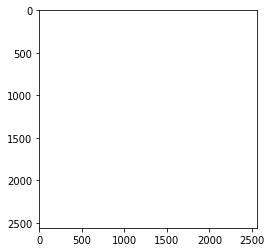

In [7]:
proj_plane = 0

if (proj_plane == 0):
    d_size_u = data_size[0]
    d_size_v = data_size[1]
    depth    = data_size[2]
    
if (proj_plane == 1):
    d_size_u = data_size[0]
    d_size_v = data_size[2]
    depth    = data_size[1]

    
if (proj_plane == 2):
    d_size_u = data_size[1]
    d_size_v = data_size[2]
    depth    = data_size[0]


width =  d_size_u*10
height = d_size_v*10
step = 0.01
max_steps = (depth/step)
print("step and max steps", step, max_steps)

pixelArray = np.zeros([width, height, 4], dtype = np.uint8)

renderData(pixelArray, data_ptr, grad_ptr, height, width, step,
               max_steps, d_size_u, d_size_v, data_size, proj_plane)
pixelArray = pixelArray.transpose(1, 0, 2)

displayImage(pixelArray, "./neghip1.png")
